## Using EvoMLP to predict fuel consumption

A simple example with the *mpg* dataset from seaborn. It's a small dataset with about 400 rows of data which can be loaded using *seaborn.load_dataset("mpg")*. 

There where some missing values which are filled in using linear regression, and the categeorical columns are one-hot encoded with drop first. The result is 9 features and 1 column to predict on.

In [39]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

df = pickle.load(open("sns_mpg.p", "rb"))
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


Let's split the dataset into train, validation and test parts to be able to evaluate the model(s)

In [40]:
X, y = df.drop(["mpg"], axis = 1).values, df["mpg"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((318, 9), (40, 9), (40, 9), (318,), (40,), (40,))

Standardizing features using Sklearn's StandardScaler, z = (x - u) / s. (Removing the mean and scaling to variance)

In [41]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

Importing the EvoMLPRegressor from evolutionary_algos.py and instantiating a regressor with 48 MLP nets with 16 hidden layers. There are some parameters to tune and this is just a basic example. The hidden layers will by default have a ReLU activation function and as we are using the regressor, the output is linear.

The regressor is then fitted over 1000 epochs and validation data is used to be able to catch overfitting of the nets.

Execution time on this laptop is about 0.6s.

In [42]:
from evolutionary_algos import EvoMLPRegressor

regressor = EvoMLPRegressor(n = 48, hidden_layer_sizes = [16], random_state = 42)

regressor.fit(scaled_X_train, y_train, epochs = 1000, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 0 - loss: 10.225950767369405 - val_loss: 10.574316085557683 - sigma: 1.0149800099966677
Epoch 1 - loss: 8.067201041900564 - val_loss: 6.231929645400766 - sigma: 0.9567163976175883
Epoch 2 - loss: 5.134156479807699 - val_loss: 4.377657379558039 - sigma: 0.9018451270734162
Epoch 7 - loss: 3.782244143093803 - val_loss: 3.694006353273108 - sigma: 0.6718475300332143
Epoch 11 - loss: 3.31728208347896 - val_loss: 2.692008128877852 - sigma: 0.5315634133302428
Epoch 22 - loss: 3.0465879835330982 - val_loss: 2.9249523960640675 - sigma: 0.2816295352492394
Epoch 23 - loss: 2.9071803614104907 - val_loss: 2.341124239257693 - sigma: 0.26605403816112994
Epoch 25 - loss: 2.8630426812432823 - val_loss: 2.457668605641282 - sigma: 0.23756843930684998
Epoch 31 - loss: 2.5941978795490885 - val_loss: 2.3344173703077713 - sigma: 0.1700008717772989
Epoch 32 - loss: 2.4864415728880997 - val_loss: 2.0395313854273383 - sigma: 0.160917010159469
Epoch 34 - loss: 2.4626487186718857 - val_loss: 2.01275060826964

Predicting on unseen data rows using the predict method is straight forward.

In [43]:
y_pred = regressor.predict(scaled_X_test)
y_pred

array([27.65176361, 32.65071127, 26.76185299, 39.28299608, 14.84064125,
       19.78872588, 15.06953527, 33.53340665, 13.81477573, 25.24662098,
       26.99690256, 25.19215497, 35.05025175, 12.07671727, 25.47121052,
       35.11311494, 19.24614639, 31.92118958, 13.95566904, 24.44267407,
       19.30422033, 20.00243896, 26.43967488, 22.29465697, 35.92210808,
       23.30247859, 22.15552395, 26.74220408, 29.78533881, 25.84358678,
       17.86096007, 18.60295555, 12.15377146, 21.02185334, 12.71546834,
       39.64879995, 23.07451285, 47.53040331, 24.01083667, 14.61555135])

The regressor has a .training_loss_history and a .validation_loss_history property which can be useful while tuning a model. 

Loss on test data: 1.7093769775391805


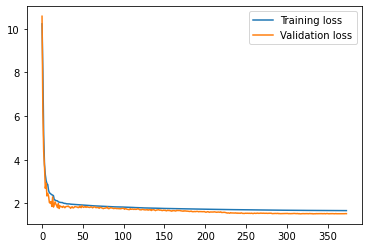

In [44]:
print(f"Loss on test data: {mean_absolute_error(y_test, y_pred)}")

fig, ax = plt.subplots(1, 1)
ax.plot(regressor.training_loss_history, label = "Training loss")
ax.plot(regressor.validation_loss_history, label = "Validation loss")
plt.legend()
plt.show()